# TIME SERIES

In [104]:
## import the necessary libraries for time series modelling
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

### Data Exploration

In [2]:
## read in train and test dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
## checking for any null values
print('train_df')
print(train_df.isnull().sum())
print('\ntest_df')
print(test_df.isnull().sum())

train_df
Date     0
T        0
RH       0
Gas      0
Value    0
dtype: int64

test_df
id      0
Date    0
T       0
RH      0
Gas     0
dtype: int64


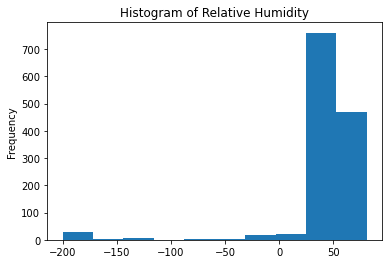

In [4]:
## check distribution in 'RH' column
train_df['RH'].plot(kind='hist')
plt.title("Histogram of Relative Humidity")
plt.show()

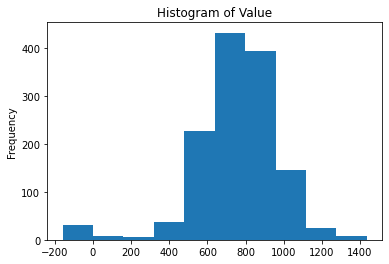

In [5]:
## check distribution in 'Value' column
train_df['Value'].plot(kind='hist')
plt.title("Histogram of Value")
plt.show()

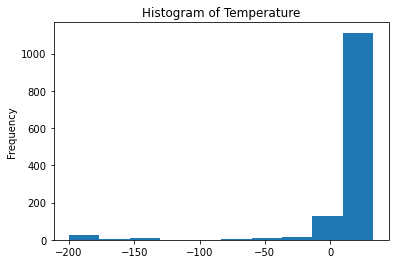

In [6]:
## check distribution in 'Value' column
train_df['T'].plot(kind='hist')
plt.title("Histogram of Temperature")
plt.show()

#### Insights From Data Exploration:
##### ‎
##### Although there are no null values within the dataset, the histograms plotted show that there are some nonsense values that have to be cleaned. 
##### ‎
##### For example, the Relative Humidity column (RH) and Value column contains values < 0, which are not possible. There also seems to be some extreme values in the Temperature column (T) such as -200 degrees. These values will be handled in the next step.
### ‎

### Data Preprocessing

In [7]:
## setting the index as Date (train_df)

train_df.index = pd.to_datetime(train_df.Date , format = '%d/%m/%Y')
train_df.drop('Date',axis = 1, inplace = True)
train_df.head()

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000
2016-03-16,9.833333,64.069791,CO,995.250000
2016-03-17,11.292708,51.107292,CO,1025.250000
2016-03-18,12.866319,51.530903,CO,1064.444444
2016-03-19,16.016667,48.843750,CO,1088.741667


In [8]:
## setting the index as Date (test_df)
test_df.index = pd.to_datetime(test_df.Date , format = '%d/%m/%Y')
test_df.drop(['Date','id'],axis = 1, inplace = True)
test_df.head()

,T,RH,Gas
Date,,,
2017-02-06,6.616667,51.734375,CO
2017-02-07,7.613194,43.930903,CO
2017-02-08,7.252083,50.966667,CO
2017-02-09,7.473611,50.166319,CO
2017-02-10,5.571875,46.604167,CO


In [9]:
## identify the number of incorrect values in the train data 

train_rh = train_df['RH']
rh_count = train_rh[train_rh < 0].count()

train_value = train_df['Value']
value_count = train_value[train_value < 0].count()

train_temp = train_df['T']
temp_count = train_temp[train_temp < -50].count()

print('rh count: ' + str(rh_count))
print('value count: ' + str(value_count))
print('temperature count: ' + str(temp_count))
print('total rows: ' + str(train_df['RH'].count()))

rh count: 64
value count: 31
temperature count: 56
total rows: 1312


In [10]:
test_rh = test_df['RH']
rh_count = test_rh[test_rh < 0].count()

test_temp = test_df['T']
temp_count = test_temp[test_temp < -50].count()

print('rh count: ' + str(rh_count))
print('temperature count: ' + str(temp_count))
print('total rows: ' + str(test_df['RH'].count()))

rh count: 16
temperature count: 16
total rows: 252


In [11]:
## handling irregular values in train data
# train_df['Value'] = np.where(train_df['Value']<0, np.nan, train_df['Value'])
# train_df['Value'] = train_df['Value'].fillna(method='ffill')

# train_df['RH'] = np.where(train_df['RH']<0, np.nan, train_df['RH'])
# train_df['RH'] = train_df['RH'].fillna(method='ffill')

# train_df['T'] = np.where(train_df['T']<-50, np.nan, train_df['T'])
# train_df['T'] = train_df['T'].fillna(method='ffill')

In [12]:
## handling irregular values in test data
# test_df['RH'] = np.where(test_df['RH']<0, np.nan, test_df['RH'])
# test_df['RH'] = test_df['RH'].fillna(method='ffill')

# test_df['T'] = np.where(test_df['T']<-25, np.nan, test_df['T'])
# test_df['T'] = test_df['T'].fillna(method='ffill')

## CO GAS

In [13]:
## extract CO gas only
CO = train_df.loc[train_df['Gas'] == "CO"]
CO = CO.drop(columns=['Gas'])
CO.head()

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,1053.200000
2016-03-16,9.833333,64.069791,995.250000
2016-03-17,11.292708,51.107292,1025.250000
2016-03-18,12.866319,51.530903,1064.444444
2016-03-19,16.016667,48.843750,1088.741667


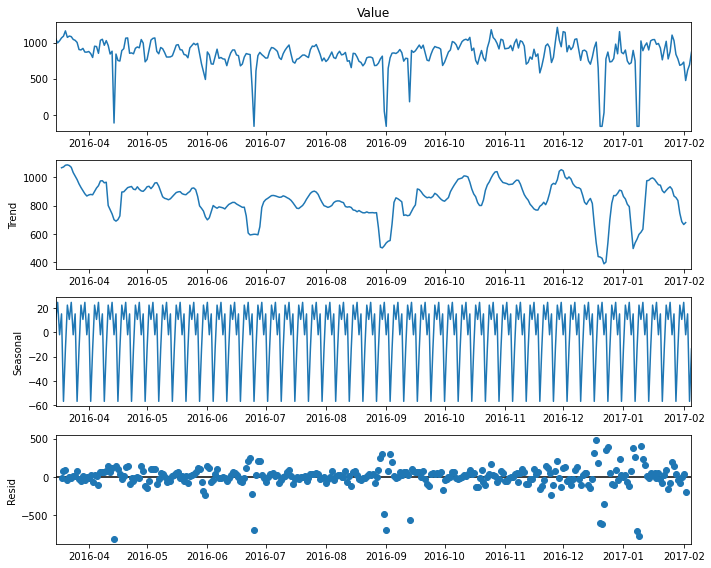

In [14]:
## CO gas decomposition plot
result = seasonal_decompose(CO['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

#### Seasonal ACF and PACF Plots

From the seasonal acf plot, we can see that there is seasonality, with a period of 7

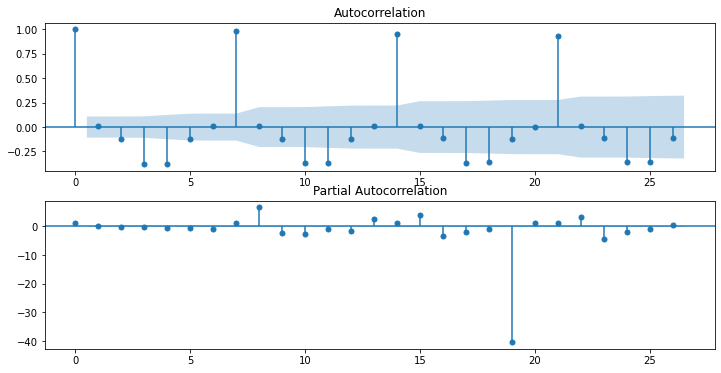

In [15]:
## CO gas seasonal ACF and PCAF plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

In [16]:
## identify min and max index in the dataframe
index = CO.index
mindex = index.min()
maxdex = index.max()

print("min index: " + str(mindex))
print("max index: " + str(maxdex))

min index: 2016-03-15 00:00:00
max index: 2017-02-05 00:00:00


In [17]:
## checking for stationarity
CO1 = CO[CO.index<='2016-08-20']
CO2 = CO[CO.index>'2016-08-20']
CO1Mean = CO1['Value'].mean()
CO2Mean = CO2['Value'].mean()
CO1Var = CO1['Value'].var()
CO2Var = CO2['Value'].var()
print(f'Group 1 Mean: {CO1Mean} | Group 2 Mean: {CO2Mean}')
print(f'Group 1 Var: {CO1Var} | Group 2 Var: {CO2Var}')

Group 1 Mean: 849.2400943364785 | Group 2 Mean: 832.4390861412428
Group 1 Var: 25955.824472213404 | Group 2 Var: 57115.78346891563


Although the means of the 2 groups are very similar, the variances are somewhat significantly different.

In [18]:
## conduct augmented dicky fuller test
pval = adfuller(CO['Value'])
print('p-val of CO Gas: %f' % pval[1])

p-val of CO Gas: 0.000000


The p-value is 0, which is lesser than 0.05. Hence, we can reject the null hypothesis(H0), the data does not have a unit root and is stationary.

### ACF and PACF Plots to obtain p,d,q values

From the PACF plot, p=1
From the ACF plot, q=1
Since time series is stationary, d=0

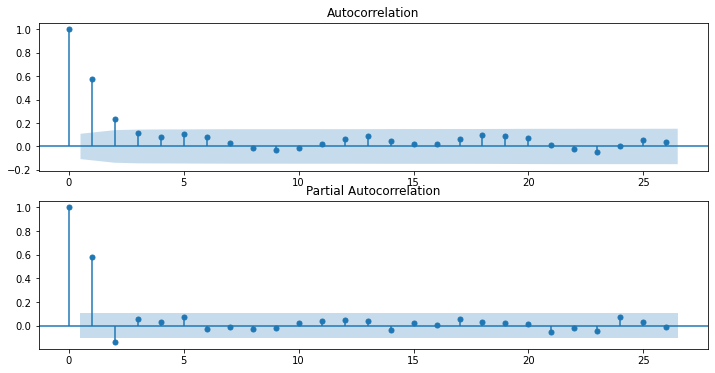

In [160]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(CO['Value'], ax=ax[0])
plot_pacf(CO['Value'], ax=ax[1])
plt.show()

### SARIMAX GridSearch

In [124]:
## split into train and test data
train_data = CO[CO.index<='2016-08-20']
test_data = CO[CO.index>'2016-08-20']

In [21]:
## define params
# orders = [(1,0,1),(1,0,2),(1,0,3),
#           (1,1,1),(1,1,2),(1,1,3),
#           (2,0,1),(2,0,2),(2,0,3),
#           (2,1,1),(2,1,2),(2,1,3)]

# seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,0,3,7),
#                    (1,1,1,7),(1,1,2,7),(1,1,3,7),
#                    (2,0,1,7),(2,0,2,7),(2,0,3,7),
#                    (2,1,1,7),(2,1,2,7),(2,1,3,7)]

# trainExog = train_data[['T','RH']]
# predExog = test_data[['T','RH']]

In [22]:
# prediction_df = pd.DataFrame()
# metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

# for order in orders:
#     for seasonal_order in seasonal_orders:
#         print("trying "+str(order),str(seasonal_order))
#         try:
#             arima_model = SARIMAX(train_data['Value'], order=order,
#                           seasonal_order=seasonal_order,
#                           trend='n', exog=trainExog).fit()
        
#             pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
#             prediction_df[f'{order},{seasonal_order}'] = pred

#             rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
#             rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
#             metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
#         except:
#             print("LU decomposition error.")

In [23]:
# metrics_df = metrics_df.sort_values('AIC')
# metrics_df

### SARIMAX 

Since this data has seasonality, we will use SARIMAX instead of ARIMA

In [181]:
exogCO = CO[['T','RH']]

arima_model = ARIMA(CO['Value'], order=(1,0,1), exog=exogCO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Value   No. Observations:                  328
Model:                     ARMA(1, 1)   Log Likelihood               -1871.861
Method:                       css-mle   S.D. of innovations             72.746
Date:                Wed, 27 Jul 2022   AIC                           3755.723
Time:                        22:56:02   BIC                           3778.481
Sample:                    03-15-2016   HQIC                          3764.803
                         - 02-05-2017                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         690.8546     15.173     45.532      0.000     661.116     720.593
T               0.6649      0.459      1.449      0.147      -0.234       1.564
RH              3.5895      0.402      8.938      0.000       2.802       4.377
ar.L1.Value     0.5101      0.068      7.449      0.000       0.376       0.644
ma.L1.Value     0.2790      0.076      3.669      0.000       0.130       0.428
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9604           +0.0000j            1.9604            0.0000
MA.1           -3.5838           +0.0000j            3.5838            0.5000
-----------------------------------------------------------------------------
"""

In [161]:
orders = [(1,0,1),(1,0,2),
          (1,1,1),(1,1,2),
          (2,0,1),(2,0,2),
          (2,1,1),(2,1,2),
          (3,0,1),(3,0,2),
          (3,1,1),(3,1,2)]

trainExog = train_data[['T','RH']]
predExog = test_data[['T','RH']]

In [133]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC', 'BIC'])

for order in orders:
    print("trying "+ str(order))
    try:
        arima_model = ARIMA(CO['Value'], order=order, exog=trainExog).fit()
        
        pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
        prediction_df[f'{order},{seasonal_order}'] = pred

        rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
        rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
        metrics_df = metrics_df.append({'model': f'{order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
    except:
        print("LU decomposition error.")

trying (1, 0, 1)
LU decomposition error.
trying (1, 0, 2)
LU decomposition error.
trying (1, 0, 3)
LU decomposition error.
trying (1, 1, 1)
LU decomposition error.
trying (1, 1, 2)
LU decomposition error.
trying (1, 1, 3)
LU decomposition error.
trying (2, 0, 1)
LU decomposition error.
trying (2, 0, 2)
LU decomposition error.
trying (2, 0, 3)
LU decomposition error.
trying (2, 1, 1)
LU decomposition error.
trying (2, 1, 2)
LU decomposition error.
trying (2, 1, 3)
LU decomposition error.


In [182]:
orders = [(1,0,1),(1,0,2),
          (1,1,1),(1,1,2),
          (2,0,1),(2,0,2),
          (2,1,1),(2,1,2),
          (3,0,1),(3,0,2),
          (3,1,1),(3,1,2)]

metrics_df = pd.DataFrame(columns=['model', 'AIC', 'BIC'])

for order in orders:
    print("trying "+ str(order))
    try:
        arima_model = ARIMA(CO['Value'], order=order, exog=exogCO).fit()
        metrics_df = metrics_df.append({'model':order, 'AIC':arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
    except:
        print('failed')

trying (1, 0, 1)
trying (1, 0, 2)
trying (1, 1, 1)
trying (1, 1, 2)
trying (2, 0, 1)
trying (2, 0, 2)
trying (2, 1, 1)
trying (2, 1, 2)
trying (3, 0, 1)
trying (3, 0, 2)
failed
trying (3, 1, 1)
trying (3, 1, 2)


In [183]:
metrics_df = metrics_df.sort_values('AIC')
metrics_df

,model,AIC,BIC
0,"(1, 0, 1)",3755.722885,3778.480966
1,"(1, 0, 2)",3757.718608,3784.269703
4,"(2, 0, 1)",3757.719816,3784.270911
5,"(2, 0, 2)",3759.575774,3789.919883
8,"(3, 0, 1)",3760.712784,3791.056893
3,"(1, 1, 2)",4281.182675,4307.712397
6,"(2, 1, 1)",4282.240360,4308.770081
9,"(3, 1, 1)",4282.397890,4312.717572
7,"(2, 1, 2)",4282.757958,4313.077640
10,"(3, 1, 2)",4284.703487,4318.813129


In [24]:
# exogCO = CO[['T','RH']]

# ## fit the data into the SARIMAX model
# arima_model = SARIMAX(CO['Value'], order=(2,1,2),
#                       seasonal_order=(1, 1, 1, 7), trend='n',exog=exogCO).fit()
# arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -1815.967
Date:                             Wed, 27 Jul 2022   AIC                           3649.933
Time:                                     21:39:28   BIC                           3683.848
Sample:                                 03-15-2016   HQIC                          3663.476
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.3347      0.472      0.709      0.479      -0.591       1.260
RH             3.8765      0.404      9.588      0.000       3.084       4.669
ar.L1         -0.3008      0.079     -3.806      0.000      -0.456      -0.146
ar.L2          0.6845      0.066     10.415      0.000       0.556       0.813
ma.L1         -0.0020      0.130     -0.015      0.988      -0.257       0.253
ma.L2         -0.9980      0.104     -9.610      0.000      -1.202      -0.794
ar.S.L7       -0.0880      0.061     -1.432      0.152      -0.209       0.032
ma.S.L7       -0.9244      0.033    -27.747      0.000      -0.990      -0.859
sigma2      4625.3242   3.46e-05   1.34e+08      0.000    4625.324    4625.324
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):                 4.05
Prob(Q):                              0.17   Prob(JB):                         0.13
Heteroskedasticity (H):               1.67   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+24. Standard errors may be unstable.
"""

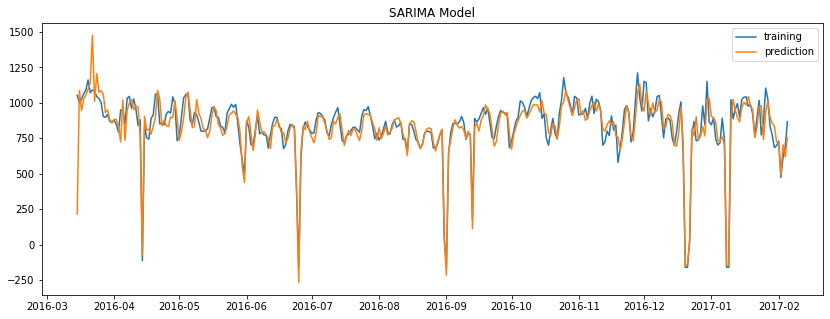

In [25]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(CO['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [26]:
mae = mean_absolute_error(CO['Value'], pred)
mape = mean_absolute_percentage_error(CO['Value'], pred)
mse = mean_squared_error(CO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,58.427731,0.072494,7587.399574,87.10568


In [27]:
## define CO test set
CO_test = test_df.loc[test_df['Gas'] == "CO"]
CO_test = CO_test.drop(columns=['Gas'])

the forecast contains a confidence interval, indicating that although actual value can be greater than or less than the forecasted vallue, it will still fall in range of the confidence interval

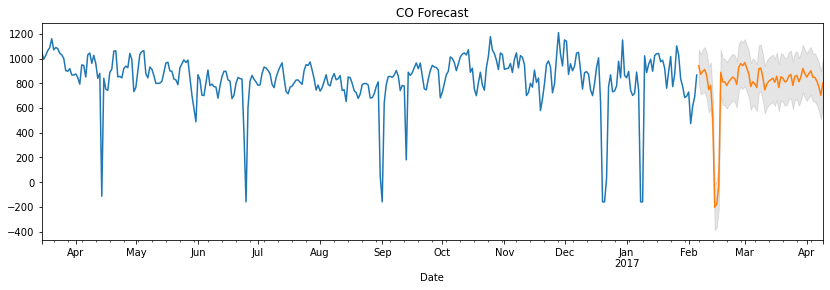

In [28]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=CO_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = CO['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("CO Forecast")
plt.show()

In [29]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=CO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('CO Forecast.csv', index=False)

## HC GAS

In [34]:
## extract HC gas only
HC = train_df.loc[train_df['Gas'] == "HC"]
HC = HC.drop(columns=['Gas'])
HC

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,729.800000
2016-03-16,9.833333,64.069791,681.441667
2016-03-17,11.292708,51.107292,806.583333
2016-03-18,12.866319,51.530903,794.258333
2016-03-19,16.016667,48.843750,755.083333
...,...,...,...
2017-02-01,5.267708,39.614930,562.650000
2017-02-02,-55.515972,-24.010417,347.480556
2017-02-03,-14.272917,28.563542,414.475000


<AxesSubplot:xlabel='Value'>

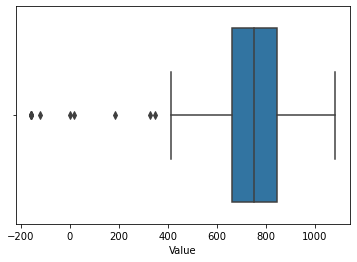

In [35]:
sns.boxplot(HC['Value'])

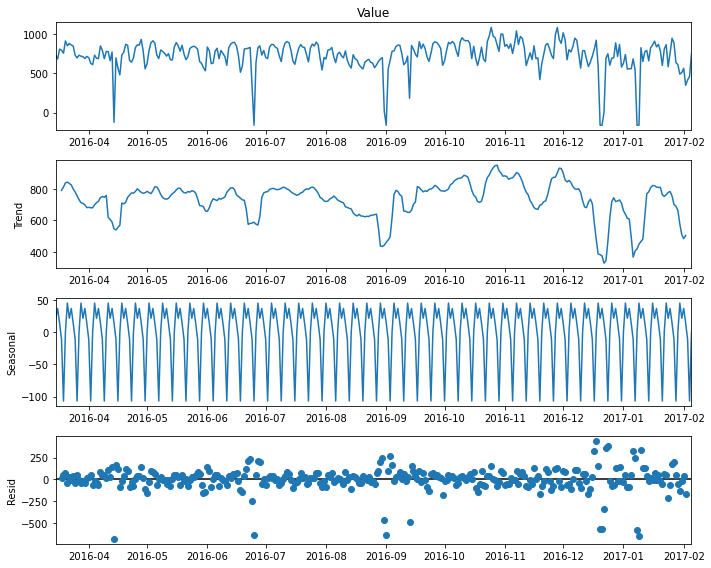

In [36]:
## HC gas decomposition plot
result = seasonal_decompose(HC['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

#### Seasonal ACF and PACF plots

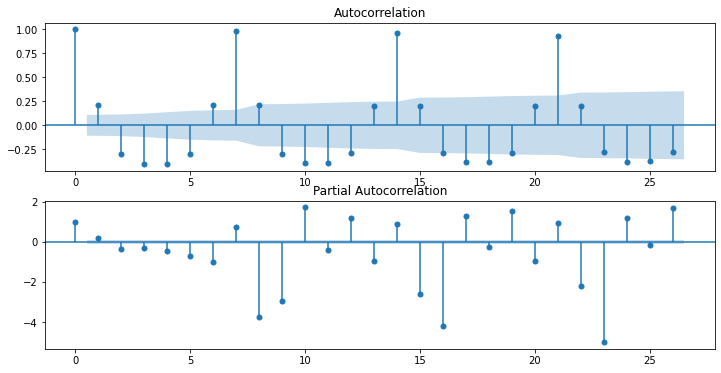

In [37]:
## plot seasonal ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

In [38]:
## check for stationarity
HC1 = HC[HC.index<='2016-08-20']
HC2 = HC[HC.index>'2016-08-20']
HC1Mean = HC1['Value'].mean()
HC2Mean = HC2['Value'].mean()
HC1Var = HC1['Value'].var()
HC2Var = HC2['Value'].var()
print(f'Group 1 Mean: {HC1Mean} | Group 2 Mean: {HC2Mean}')
print(f'Group 1 Var: {HC1Var} | Group 2 Var: {HC2Var}')

Group 1 Mean: 735.9289133459121 | Group 2 Mean: 723.6241781651065
Group 1 Var: 20498.650280551938 | Group 2 Var: 51263.895697084175


In [39]:
## conduct augmented dicky fuller test
pval = adfuller(HC['Value'])
print('p-val of HC Gas: %f' % pval[1])

p-val of HC Gas: 0.000000


#### ACF and PACF Plots to obtain p,d,q values

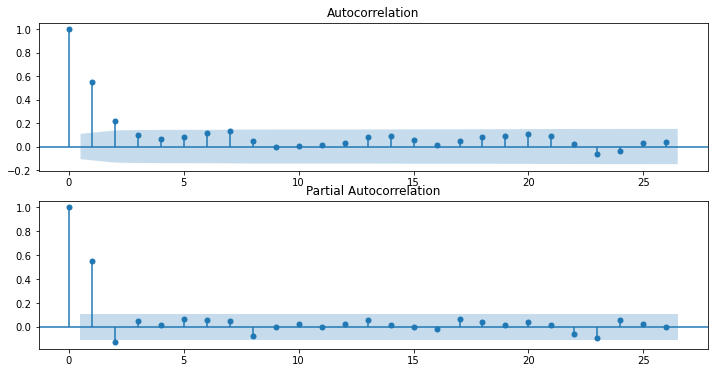

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(HC['Value'], ax=ax[0])
plot_pacf(HC['Value'], ax=ax[1])
plt.show()

#### SARIMAX GridSearch

In [41]:
## split into train and test data
train_data = HC[HC.index<='2016-08-20']
test_data = HC[HC.index>'2016-08-20']

In [42]:
## define params
# orders = [(1,0,1),(1,0,2),(1,1,1),(1,1,2),
#           (2,0,1),(2,0,2),(2,1,1),(2,1,2),
#           (3,0,1),(3,0,2),(3,1,1),(3,1,2),
#           (4,0,1),(4,0,2),(4,1,1),(4,1,2),
#           (5,0,1),(5,0,2),(5,1,1),(5,1,2)]

# seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,1,1,7),(1,1,2,7),
#           (2,0,1,7),(2,0,2,7),(2,1,1,7),(2,1,2,7),
#           (3,0,1,7),(3,0,2,7),(3,1,1,7),(3,1,2,7),
#           (4,0,1,7),(4,0,2,7),(4,1,1,7),(4,1,2,7),
#           (5,0,1,7),(5,0,2,7),(5,1,1,7),(5,1,2,7)]

# trainExog = train_data[['T','RH']]
# predExog = test_data[['T','RH']]

In [43]:
# prediction_df = pd.DataFrame()
# metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

# for order in orders:
#     for seasonal_order in seasonal_orders:
#         print("trying "+str(order),str(seasonal_order))
#         try:
#             arima_model = SARIMAX(train_data['Value'], order=order,
#                           seasonal_order=seasonal_order,
#                           trend='n', exog=trainExog).fit()
        
#             pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
#             prediction_df[f'{order},{seasonal_order}'] = pred

#             rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
#             rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
#             metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
#         except:
#             print("LU decomposition error.")

In [44]:
# metrics_df = metrics_df.sort_values('RMSE_test')
# metrics_df

### SARIMAX 

In [45]:
exogHC = HC[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(HC['Value'], order=(1,0,1),
                      seasonal_order=(1, 0, 1, 7), trend='n',exog=exogHC).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -1903.864
Date:                           Wed, 27 Jul 2022   AIC                           3821.728
Time:                                   21:40:13   BIC                           3848.279
Sample:                               03-15-2016   HQIC                          3832.321
                                    - 02-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              2.7026      0.550      4.910      0.000       1.624       3.781
RH             1.2826      0.459      2.796      0.005       0.384       2.182
ar.L1          0.8882      0.037     23.901      0.000       0.815       0.961
ma.L1         -0.1978      0.062     -3.204      0.001      -0.319      -0.077
ar.S.L7        0.9995      0.001    935.450      0.000       0.997       1.002
ma.S.L7       -0.9698      0.032    -30.465      0.000      -1.032      -0.907
sigma2      5912.9152    458.818     12.887      0.000    5013.649    6812.182
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                 4.46
Prob(Q):                              0.35   Prob(JB):                         0.11
Heteroskedasticity (H):               1.99   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

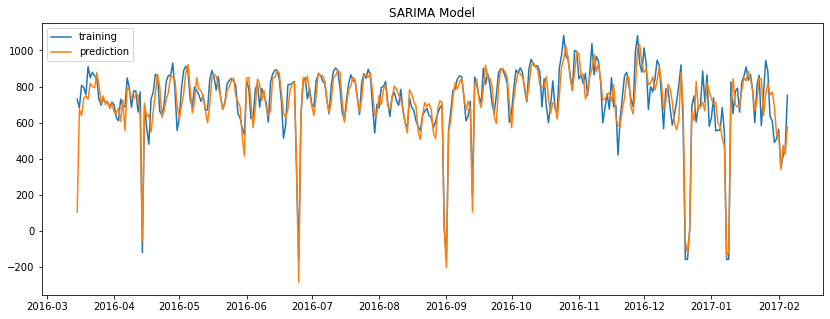

In [46]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(HC['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [47]:
mae = mean_absolute_error(HC['Value'], pred)
mape = mean_absolute_percentage_error(HC['Value'], pred)
mse = mean_squared_error(HC['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,62.216856,0.142999,7432.496213,86.211926


In [48]:
## define HC test set
HC_test = test_df.loc[test_df['Gas'] == "HC"]
HC_test = HC_test.drop(columns=['Gas'])

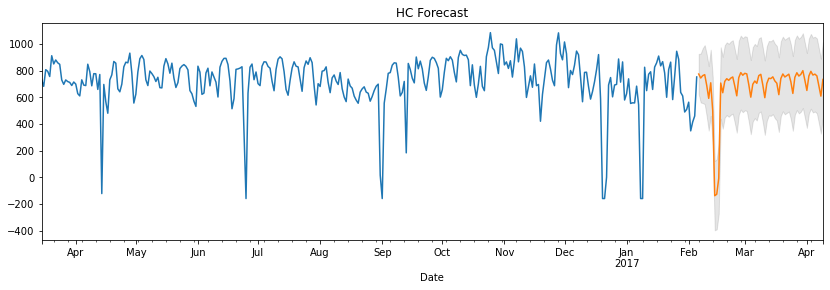

In [49]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=HC_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = HC['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("HC Forecast")
plt.show()

In [50]:
# obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=HC_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('HC Forecast.csv', index=False)

^^ less fitting might be due to outliers in 'HC'

## NO2 Gas

In [55]:
## extract NO2 gas only
NO = train_df.loc[train_df['Gas'] == "NO2"]
NO = NO.drop(columns=['Gas'])
NO

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,933.800000
2016-03-16,9.833333,64.069791,1021.750000
2016-03-17,11.292708,51.107292,881.375000
2016-03-18,12.866319,51.530903,794.527778
2016-03-19,16.016667,48.843750,800.883333
...,...,...,...
2017-02-01,5.267708,39.614930,797.647222
2017-02-02,-55.515972,-24.010417,508.180556
2017-02-03,-14.272917,28.563542,819.733333


<AxesSubplot:xlabel='Value'>

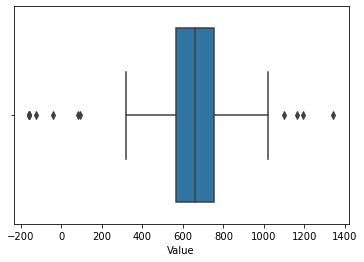

In [56]:
sns.boxplot(NO['Value'])

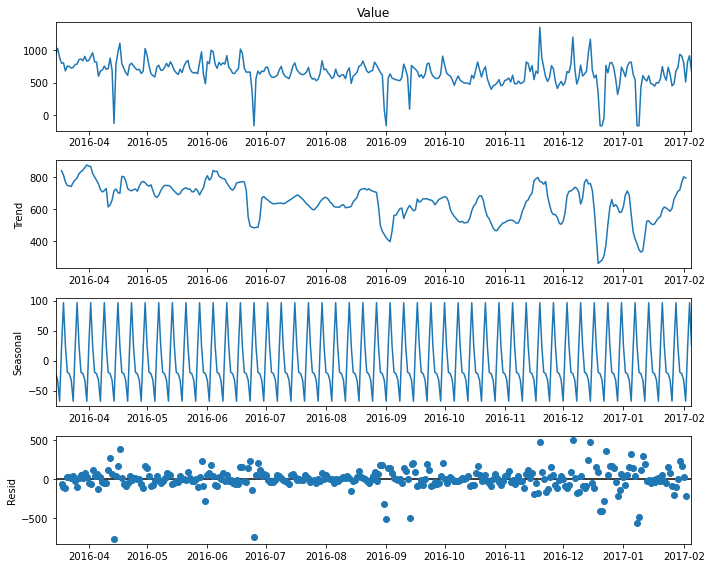

In [57]:
## NO2 gas decomposition plot
result = seasonal_decompose(NO['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

#### Seasonal ACF and PACF Plots

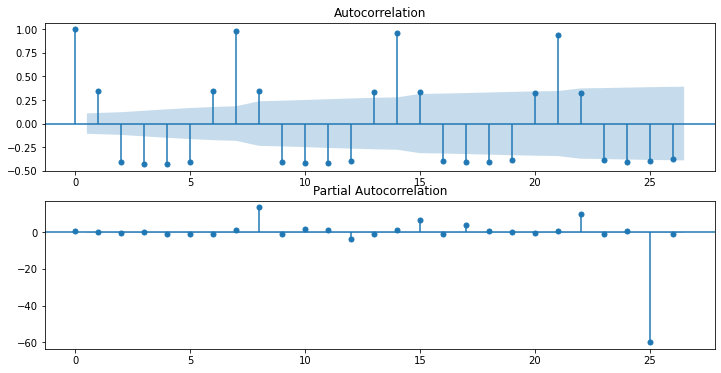

In [58]:
## plot seasonal ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

In [59]:
## check for stationarity
NO1 = NO[NO.index<='2016-08-20']
NO2 = NO[NO.index>'2016-08-20']
NO1Mean = NO1['Value'].mean()
NO2Mean = NO2['Value'].mean()
NO1Var = NO1['Value'].var()
NO2Var = NO2['Value'].var()
print(f'Group 1 Mean: {NO1Mean} | Group 2 Mean: {NO2Mean}')
print(f'Group 1 Var: {NO1Var} | Group 2 Var: {NO2Var}')

Group 1 Mean: 707.6746680654088 | Group 2 Mean: 595.908777123905
Group 1 Var: 23166.116227942657 | Group 2 Var: 45119.29175581713


In [60]:
## conduct augmented dicky fuller test
pval = adfuller(NO['Value'])
print('p-val of NO2 Gas: %f' % pval[1])

p-val of NO2 Gas: 0.000000


#### ACF and PACF Plots to obtain p,d,q values

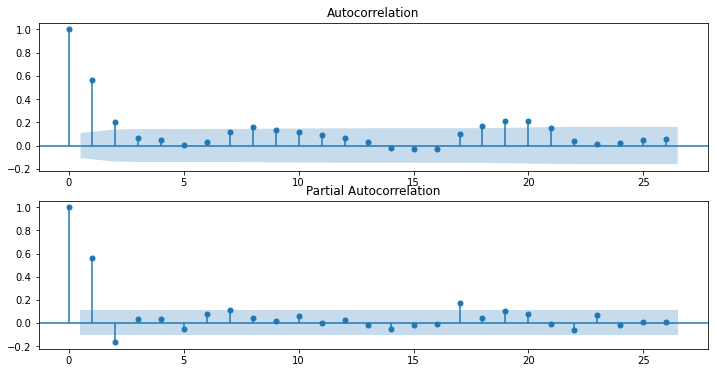

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(NO['Value'], ax=ax[0])
plot_pacf(NO['Value'], ax=ax[1])
plt.show()

#### SARIMAX GridSearch

In [62]:
## split into train and test data
train_data = NO[NO.index<='2016-08-20']
test_data = NO[NO.index>'2016-08-20']

In [63]:
## define params
# orders = [(1,0,1),(1,0,2),(1,1,1),(1,1,2),
#           (2,0,1),(2,0,2),(2,1,1),(2,1,2),
#           (3,0,1),(3,0,2),(3,1,1),(3,1,2),
#           (4,0,1),(4,0,2),(4,1,1),(4,1,2),
#           (5,0,1),(5,0,2),(5,1,1),(5,1,2),
#           (6,0,1),(6,0,2),(6,1,1),(6,1,2)]

# seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,1,1,7),(1,1,2,7),
#           (2,0,1,7),(2,0,2,7),(2,1,1,7),(2,1,2,7),
#           (3,0,1,7),(3,0,2,7),(3,1,1,7),(3,1,2,7),
#           (4,0,1,7),(4,0,2,7),(4,1,1,7),(4,1,2,7),
#           (5,0,1,7),(5,0,2,7),(5,1,1,7),(5,1,2,7),
#           (6,0,1,),(6,0,2,7),(6,1,1,7),(6,1,2,7)]

# trainExog = train_data[['T','RH']]
# predExog = test_data[['T','RH']]

In [64]:
# prediction_df = pd.DataFrame()
# metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

# for order in orders:
#     for seasonal_order in seasonal_orders:
#         print("trying "+str(order),str(seasonal_order))
#         try:
#             arima_model = SARIMAX(train_data['Value'], order=order,
#                           seasonal_order=seasonal_order,
#                           trend='n', exog=trainExog).fit()
        
#             pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
#             prediction_df[f'{order},{seasonal_order}'] = pred

#             rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
#             rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
#             metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
#         except:
#             print("LU decomposition error.")

In [65]:
# metrics_df = metrics_df.sort_values('AIC')
# metrics_df

### SARIMAX

In [66]:
exogNO = NO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(NO['Value'], order=(1,0,2),
                      seasonal_order=(1, 0, 1, 7), trend='n',exog=exogNO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -1988.908
Date:                             Wed, 27 Jul 2022   AIC                           3993.816
Time:                                     21:40:33   BIC                           4024.160
Sample:                                 03-15-2016   HQIC                          4005.923
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              5.3178      0.720      7.389      0.000       3.907       6.728
RH            -1.3956      0.607     -2.300      0.021      -2.585      -0.206
ar.L1          0.9998      0.001   1653.426      0.000       0.999       1.001
ma.L1         -0.3940      0.039    -10.153      0.000      -0.470      -0.318
ma.L2         -0.4532      0.040    -11.402      0.000      -0.531      -0.375
ar.S.L7        0.9782      0.030     32.161      0.000       0.919       1.038
ma.S.L7       -0.9237      0.062    -14.946      0.000      -1.045      -0.803
sigma2      1.053e+04    432.499     24.339      0.000    9678.889    1.14e+04
===================================================================================
Ljung-Box (L1) (Q):                   3.91   Jarque-Bera (JB):              1226.55
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               2.38   Skew:                             1.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
mae = mean_absolute_error(NO['Value'], pred)
mape = mean_absolute_percentage_error(NO['Value'], pred)
mse = mean_squared_error(NO['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,182.298446,0.31073,52668.219317,229.495576


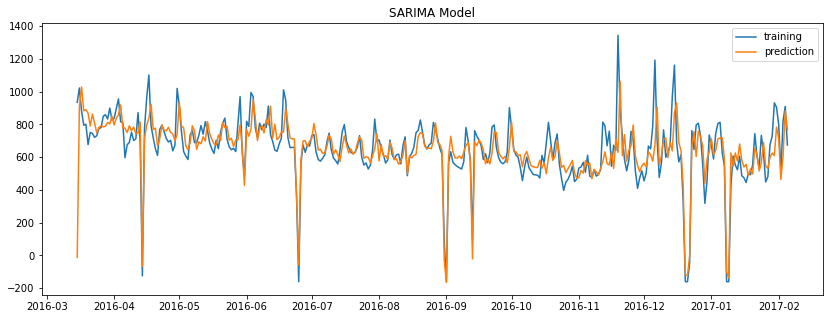

In [68]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(NO['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [69]:
## define NO test set
NO_test = test_df.loc[test_df['Gas'] == "NO2"]
NO_test = NO_test.drop(columns=['Gas'])

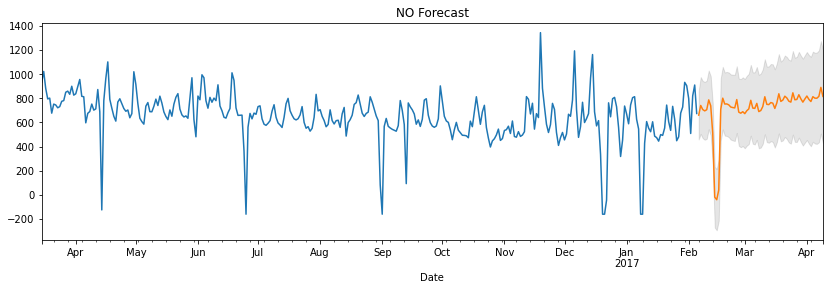

In [70]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=NO_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = NO['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("NO Forecast")
plt.show()

In [71]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=NO_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('NO2 Forecast.csv', index=False)

## O3 Gas

In [76]:
## extract O3 gas only
O = train_df.loc[train_df['Gas'] == "O3"]
O = O.drop(columns=['Gas'])
O

,T,RH,Value
Date,,,
2016-03-15,12.020833,54.883334,876.833333
2016-03-16,9.833333,64.069791,708.025000
2016-03-17,11.292708,51.107292,867.375000
2016-03-18,12.866319,51.530903,996.625000
2016-03-19,16.016667,48.843750,987.341667
...,...,...,...
2017-02-01,5.267708,39.614930,553.180556
2017-02-02,-55.515972,-24.010417,343.500000
2017-02-03,-14.272917,28.563542,334.458333


<AxesSubplot:xlabel='Value'>

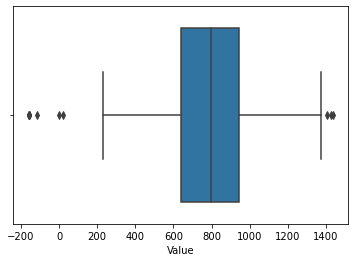

In [77]:
sns.boxplot(O['Value'])

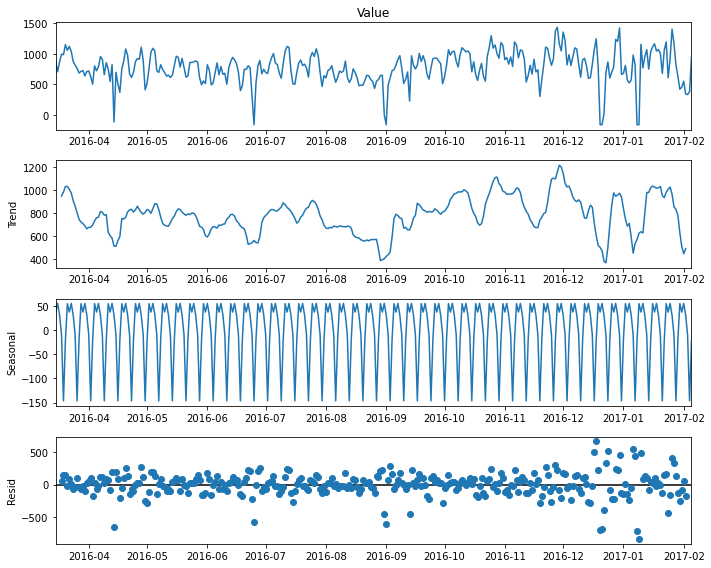

In [78]:
## O3 gas decomposition plot
result = seasonal_decompose(O['Value'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

#### Seasonal ACF and PACF Plots

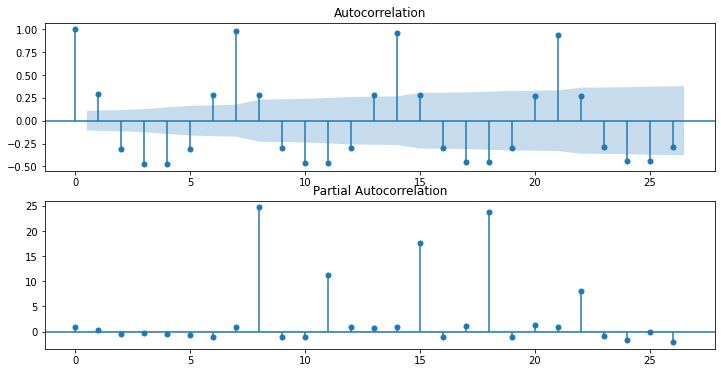

In [79]:
## plot seasonal ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

In [80]:
## check for stationarity
O1 = O[O.index<='2016-08-20']
O2 = O[O.index>'2016-08-20']
O1Mean = O1['Value'].mean()
O2Mean = O2['Value'].mean()
O1Var = O1['Value'].var()
O2Var = O2['Value'].var()
print(f'Group 1 Mean: {O1Mean} | Group 2 Mean: {O2Mean}')
print(f'Group 1 Var: {O1Var} | Group 2 Var: {O2Var}')

Group 1 Mean: 746.6952655578614 | Group 2 Mean: 812.5275148096445
Group 1 Var: 40194.815536187154 | Group 2 Var: 93537.97818321272


In [81]:
## conduct augmented dicky fuller test
pval = adfuller(O['Value'])
print('p-val of O3 Gas: %f' % pval[1])

p-val of O3 Gas: 0.000000


#### ACF and PACF Plots too obtain p,d,q values

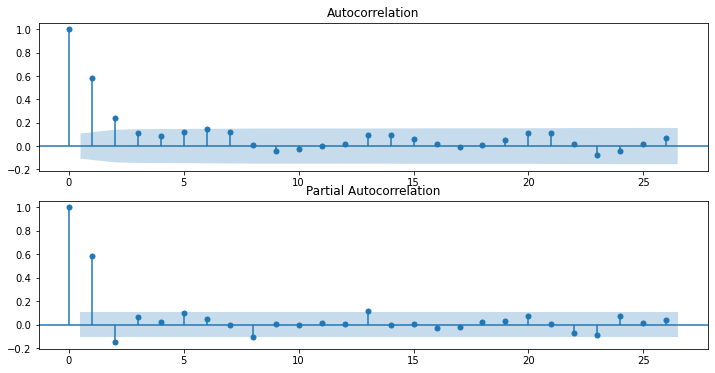

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(O['Value'], ax=ax[0])
plot_pacf(O['Value'], ax=ax[1])
plt.show()

### SARIMAX GridSearch

In [83]:
## split into train and test data
train_data = O[O.index<='2016-08-20']
test_data = O[O.index>'2016-08-20']

In [84]:
## define params
# orders = [(1,0,1),(1,0,2),(1,1,1),(1,1,2),
#           (2,0,1),(2,0,2),(2,1,1),(2,1,2),
#           (3,0,1),(3,0,2),(3,1,1),(3,1,2),
#           (4,0,1),(4,0,2),(4,1,1),(4,1,2),
#           (5,0,1),(5,0,2),(5,1,1),(5,1,2),
#           (6,0,1),(6,0,2),(6,1,1),(6,1,2)]

# seasonal_orders = [(1,0,1,7),(1,0,2,7),(1,1,1,7),(1,1,2,7),
#           (2,0,1,7),(2,0,2,7),(2,1,1,7),(2,1,2,7),
#           (3,0,1,7),(3,0,2,7),(3,1,1,7),(3,1,2,7),
#           (4,0,1,7),(4,0,2,7),(4,1,1,7),(4,1,2,7),
#           (5,0,1,7),(5,0,2,7),(5,1,1,7),(5,1,2,7),
#           (6,0,1,),(6,0,2,7),(6,1,1,7),(6,1,2,7)]

# trainExog = train_data[['T','RH']]
# predExog = test_data[['T','RH']]

In [85]:
# prediction_df = pd.DataFrame()
# metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

# for order in orders:
#     for seasonal_order in seasonal_orders:
#         print("trying "+str(order),str(seasonal_order))
#         try:
#             arima_model = SARIMAX(train_data['Value'], order=order,
#                           seasonal_order=seasonal_order,
#                           trend='n', exog=trainExog).fit()
        
#             pred = arima_model.get_prediction(start='2016-03-15', end='2017-02-05', exog=predExog).predicted_mean
#             prediction_df[f'{order},{seasonal_order}'] = pred

#             rmse_train = round(mean_squared_error(train_data['Value'], pred[pred.index<='2016-08-20'], squared=False), 2)
#             rmse_test = round(mean_squared_error(test_data['Value'], pred[pred.index>'2016-08-20'], squared=False), 2)
#             metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic, 'BIC':arima_model.bic}, ignore_index=True)
#         except:
#             print("LU decomposition error.")

In [86]:
# metrics_df = metrics_df.sort_values('AIC')
# metrics_df

### SARIMAX

In [98]:
exogO = O[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(O['Value'], order=(1,0,2),
                      seasonal_order=(1, 0, 1, 7), trend='n',exog=exogO).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Value   No. Observations:                  328
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -2112.779
Date:                             Wed, 27 Jul 2022   AIC                           4241.559
Time:                                     21:45:00   BIC                           4271.903
Sample:                                 03-15-2016   HQIC                          4253.665
                                      - 02-05-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.1930      0.990     -0.195      0.846      -2.134       1.748
RH             4.2000      0.834      5.037      0.000       2.566       5.834
ar.L1          0.9998      0.001    955.008      0.000       0.998       1.002
ma.L1         -0.4116      0.044     -9.443      0.000      -0.497      -0.326
ma.L2         -0.5757      0.044    -13.016      0.000      -0.662      -0.489
ar.S.L7        0.9916      0.012     81.541      0.000       0.968       1.015
ma.S.L7       -0.9404      0.038    -24.779      0.000      -1.015      -0.866
sigma2      2.227e+04   1773.631     12.557      0.000    1.88e+04    2.57e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.63   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.00   Prob(JB):                         0.86
Heteroskedasticity (H):               2.08   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

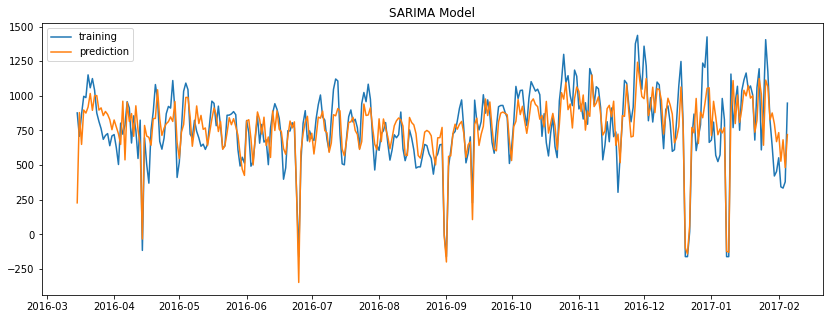

In [99]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(O['Value'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [100]:
mae = mean_absolute_error(O['Value'], pred)
mape = mean_absolute_percentage_error(O['Value'], pred)
mse = mean_squared_error(O['Value'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,122.899001,0.21954,24018.578089,154.979283


In [101]:
## define O test set
O_test = test_df.loc[test_df['Gas'] == "O3"]
O_test = O_test.drop(columns=['Gas'])

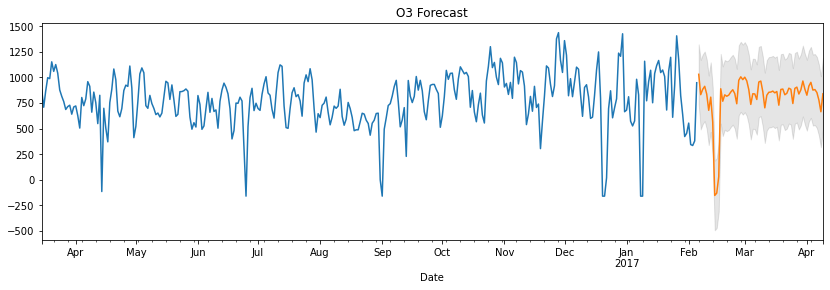

In [102]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=63, exog=O_test)

## confidence intervals
fore_ci = forecast.conf_int()
ax = O['Value'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("O3 Forecast")
plt.show()

TypeError: 'Figure' object is not subscriptable

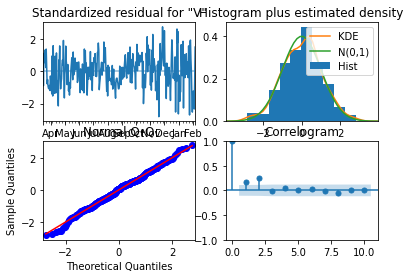

In [92]:
arima_model.plot_diagnostics()[0]

In [103]:
## obtain csv of 63 predicted values
forecast = arima_model.forecast(steps=63, exog=O_test)
forecastDF = pd.DataFrame(forecast)
forecastDF.to_csv('O3 Forecast.csv', index=False)

NOTES

1) we assume time series is additive
2) based on decomposition plot, seasonal component does not change with the changes in trend. hence 

### REFERENCES

#### https://dziganto.github.io/python/time%20series/Introduction-to-Time-Series/
#### https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
#### https://online.stat.psu.edu/stat510/lesson/5/5.1
#### https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/